# Madrid mosaic Sentinel 2


In [1]:
import geopandas
import contextily
import rioxarray, xarray
import rasterio as rio
from numpy import percentile
import matplotlib.pyplot as plt

## Identify tiles

- Load MGRS and Madrid

In [2]:
p = (
    "https://github.com/developmentseed/titiler-digitaltwin/"\
    "raw/36bf4cca96b84c79b2a299f7b5fde82ec87bb2e4/"\
    "titiler_digitaltwin/data/grid.geojson"
)
p

'https://github.com/developmentseed/titiler-digitaltwin/raw/36bf4cca96b84c79b2a299f7b5fde82ec87bb2e4/titiler_digitaltwin/data/grid.geojson'

In [3]:
mgrs = geopandas.read_file(p)
mad = geopandas.read_file("neighbourhoods.geojson")

- Intersect with MGRS to locate the tile in the 120m dataset

    name                                           geometry
211  30T  POLYGON ((-5.67287 47.82258, -5.62777 46.92300...


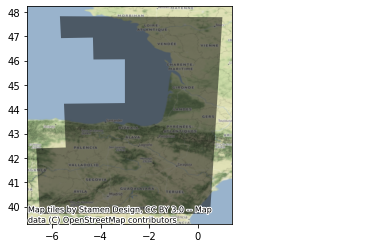

In [4]:
scene = mgrs[mgrs.contains(mad.unary_union)]
print(scene)
ax = scene.plot(color = "k", alpha=0.5)
contextily.add_basemap(ax, crs=scene.crs)

For both datasets, we need the bounding box for Madrid expressed in the tiles' CRS:

In [5]:
mad_bb = mad.to_crs(epsg=32630).total_bounds

## 120m Resolution

```{important}
Please see [here](data_s2_120) for more details
```

In [6]:
def build_da(
    year, 
    month, 
    day, 
    tile, 
    bb,
    base_url="https://sentinel-s2-l2a-mosaic-120.s3.amazonaws.com"
):
    p = f"{base_url}/{year}/{month}/{day}/{tile}/XbX.tif"
    # Connect to separate bands
    full_red = rioxarray.open_rasterio(p.replace("XbX", "B04"))
    full_green = rioxarray.open_rasterio(p.replace("XbX", "B03"))
    full_blue = rioxarray.open_rasterio(p.replace("XbX", "B02"))
    full_ir = rioxarray.open_rasterio(p.replace("XbX", "B08"))
    bands = [full_red, full_green, full_blue, full_ir]
    # Clip to bb
    scene = []
    for b in range(4):
        band = bands[b].rio.clip_box(*bb)
        scene.append(band)
    scene = xarray.concat(scene, dim="band").astype(rio.uint16)
    # Patch up meta-data
    scene.coords["band"] = ["R", "G", "B", "NIR"]
    return scene

### Pull down scenes

We will access data from the following dates:

In [7]:
dates = [
    (2019, 1, 1),
    (2019, 4, 1),
    (2019, 7, 10),
    (2019, 11, 27)
]

In a loop, we pull and write them out into its own GeoTiff:

In [8]:
%%time
for date in dates:
    y, m, d = date
    print(f"~~~~~Building {y}-{m}-{d}")
    da = build_da(*date, "30T", mad_bb)
    out_f = f"madrid_scene_s2_120_{y}-{m}-{d}.tif"
    ! rm -f $out_f
    da.rio.to_raster(out_f)
    ! du -h $out_f

~~~~~Building 2019-1-1
628K	madrid_scene_s2_120_2019-1-1.tif
~~~~~Building 2019-4-1
628K	madrid_scene_s2_120_2019-4-1.tif
~~~~~Building 2019-7-10
628K	madrid_scene_s2_120_2019-7-10.tif
~~~~~Building 2019-11-27
628K	madrid_scene_s2_120_2019-11-27.tif
CPU times: user 12.5 s, sys: 2.42 s, total: 14.9 s
Wall time: 1min 48s


## 10m Resolution

```{important}
Please see [here](data_s2_10) for more details
```


### Pull down bands

Knowing the static URL to the COG file:

In [9]:
url = (
    "http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"\
    "GHS_composite_S2_L1C_2017-2018_GLOBE_R2020A/"\
    "GHS_composite_S2_L1C_2017-2018_GLOBE_R2020A_UTM_10/"\
    "V1-0/30T/S2_percentile_UTM_269-0000069888-0000000000.tif"
)
url

'http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_composite_S2_L1C_2017-2018_GLOBE_R2020A/GHS_composite_S2_L1C_2017-2018_GLOBE_R2020A_UTM_10/V1-0/30T/S2_percentile_UTM_269-0000069888-0000000000.tif'

We can connect to it:

In [10]:
scene10m = xarray.open_rasterio(url).sel(band=[1, 2, 3])

And clip exactly the required box:

In [11]:
mad_scene = scene10m.rio.clip_box(*mad_bb)

### Color correct

In [12]:
def minmax(
    a, 
    bottom=0, 
    top=255, 
    min_cut=2.5, 
    max_cut=97.5
):
    vals = a.to_series().values
    min_bin = percentile(vals, min_cut)
    max_bin = percentile(vals, max_cut)
    a = xarray.where(a > max_bin, max_bin, a)
    a = xarray.where(a < min_bin, min_bin, a)
    a_std = (a - a.min()) / (a.max() - a.min())
    a_scaled = a_std * (top - bottom) + bottom
    return a_scaled.astype(rio.uint8)

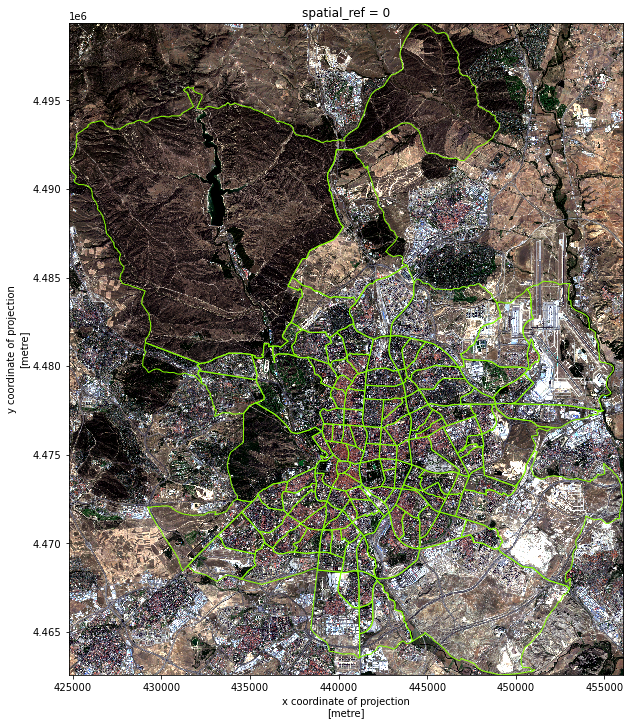

In [13]:
f, ax = plt.subplots(1, figsize=(12, 12))
mad_scene.groupby("band")\
         .map(minmax)\
         .plot.imshow(ax=ax)
mad.to_crs(mad_scene.rio.crs).plot(
    ax=ax, facecolor="none", edgecolor="xkcd:lime green", linewidth=1
);

### Write out true color

In [14]:
out_f = "madrid_scene_s2_10_tc.tif"
! rm -f $out_f

mad_scene.groupby("band")\
         .map(minmax)\
         .astype(rio.uint8)\
         .rio.to_raster(out_f)
! du -h $out_f

33M	madrid_scene_s2_10_tc.tif
